# Управление рисками 2026

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности. 

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

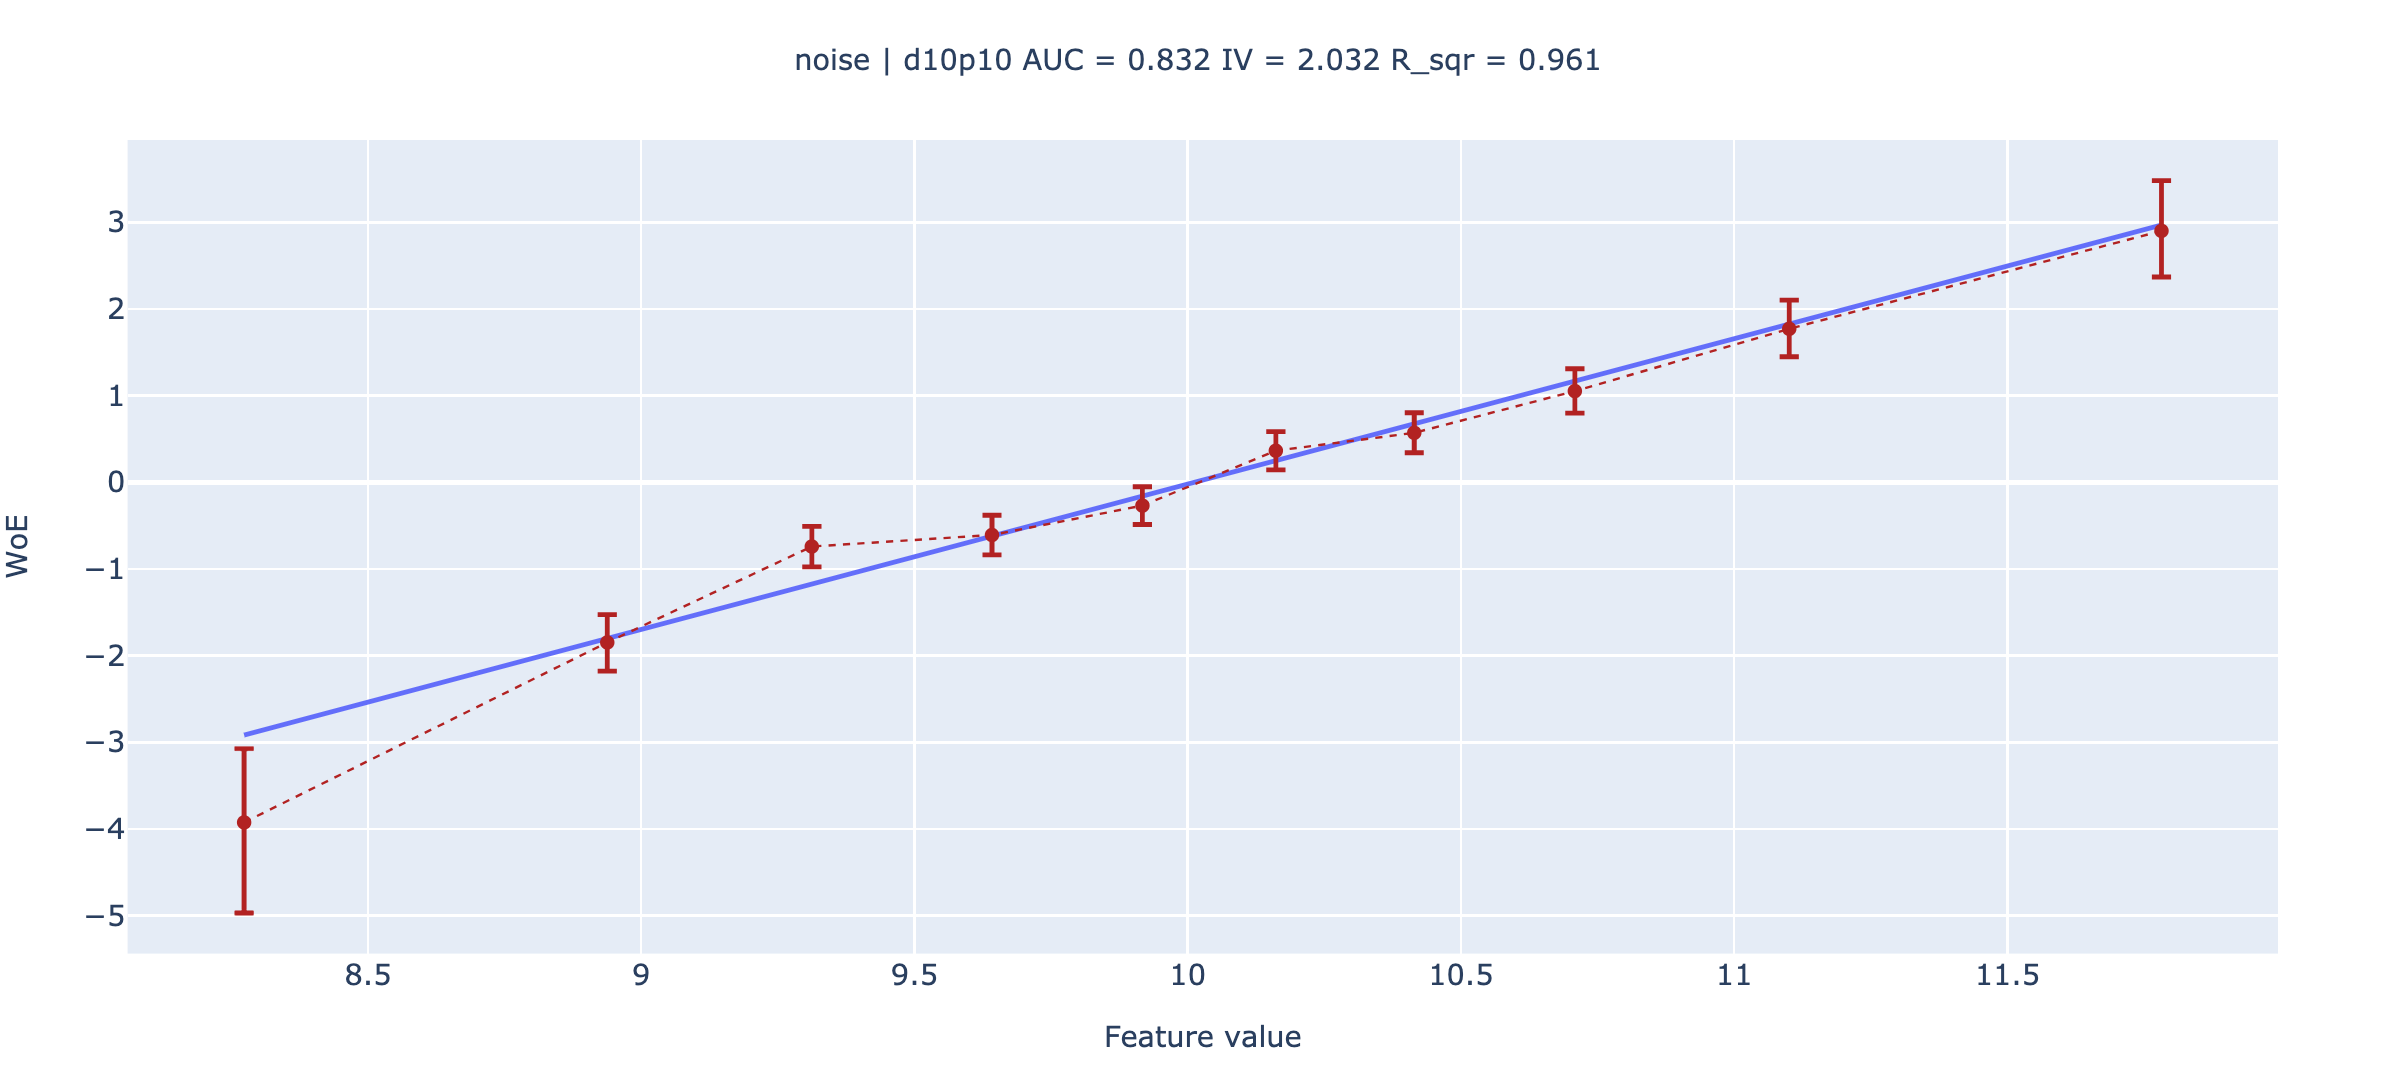

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [789]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

### Шаг 0: разбиение на бакеты

In [790]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [791]:
def test_calc_buckets():
    """Тестирование функции calc_buckets"""
    
    # Тест 1: Простой случай
    x = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    buckets = calc_buckets(x, 5)
    print("Тест 1 - простые числа:")
    print(f"  Вход: {x.tolist()}")
    print(f"  Бакеты: {buckets}")
    print(f"  Уникальные бакеты: {sorted(set(buckets))}")
    print()
    
    # Тест 2: Повторяющиеся значения
    x2 = pd.Series([1, 1, 2, 2, 3, 3, 4, 4, 5, 5])
    buckets2 = calc_buckets(x2, 3)
    print("Тест 2 - повторяющиеся значения:")
    print(f"  Вход: {x2.tolist()}")
    print(f"  Бакеты: {buckets2}")
    print()
    
    # Тест 3: Все одинаковые значения
    x3 = pd.Series([5, 5, 5, 5, 5])
    buckets3 = calc_buckets(x3, 3)
    print("Тест 3 - все значения одинаковы:")
    print(f"  Вход: {x3.tolist()}")
    print(f"  Бакеты: {buckets3}")
    print()
    
    # Тест 4: Проверка монотонности
    x4 = pd.Series(np.random.randn(100))
    buckets4 = calc_buckets(x4, 10)
    
    # Проверяем, что бакеты упорядочены
    sorted_x = np.sort(x4)
    sorted_buckets = buckets4[np.argsort(x4)]
    
    # Бакеты должны быть неубывающими
    is_monotonic = np.all(np.diff(sorted_buckets) >= 0)
    print(f"Тест 4 - монотонность на случайных данных: {'✓' if is_monotonic else '✗'}")
    print(f"  Распределение по бакетам: {np.bincount(buckets4)}")

test_calc_buckets()

Тест 1 - простые числа:
  Вход: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Бакеты: [0 0 1 1 2 2 3 3 4 4]
  Уникальные бакеты: [np.int16(0), np.int16(1), np.int16(2), np.int16(3), np.int16(4)]

Тест 2 - повторяющиеся значения:
  Вход: [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
  Бакеты: [0 0 1 1 1 1 2 2 2 2]

Тест 3 - все значения одинаковы:
  Вход: [5, 5, 5, 5, 5]
  Бакеты: [2 2 2 2 2]

Тест 4 - монотонность на случайных данных: ✓
  Распределение по бакетам: [10 10 10 10 10 10 10 10 10 10]


### Шаг 1: расчет WoE по бакетам (2 балла)

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$. 

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**: 

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) 
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где 

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

In [792]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [793]:

test_cases = [
    # (badrate, offset, описание)
    (0.1, logit(0.2), "badrate < offset"),
    (0.5, logit(0.5), "badrate = offset"),
    (0.8, logit(0.3), "badrate > offset"),
    (0.25, logit(0.1), "значительная разница"),
    (0.75, logit(0.9), "обратная значительная разница"),
]

all_passed = True
for badrate, offset, description in test_cases:
    try:
        result = woe_transform(badrate, offset)
        
        # Проверяем тип
        if not isinstance(result, (float, np.floating)):
            print(f"✗ {description}: результат не float, а {type(result)}")
            all_passed = False
            continue
            
        overall_badrate = np.exp(offset) / (1 + np.exp(offset))
        
        if badrate > overall_badrate:
            # badrate выше среднего → WoE должен быть положит
            expected_positive = True
            if result <= 0:
                print(f"⚠ {description}: badrate={badrate:.3f} > overall={overall_badrate:.3f}")
                print(f"  Ожидался ПОЛОЖИТЕЛЬНЫЙ WoE, получили {result:.4f}")
        elif badrate < overall_badrate:
            # badrate ниже среднего → WoE отриц
            expected_positive = False
            if result >= 0:
                print(f"⚠ {description}: badrate={badrate:.3f} < overall={overall_badrate:.3f}")
                print(f"  Ожидался ОТРИЦАТЕЛЬНЫЙ WoE, получили {result:.4f}")
        else:
            # badrate равен среднему → WoE должен быть ≈ 0
            if not np.isclose(result, 0, atol=1e-10):
                print(f"⚠ {description}: badrate={badrate:.3f} = overall={overall_badrate:.3f}")
                print(f"  Ожидался WoE ≈ 0, получили {result:.4f}")
        
        print(f"✓ {description}:")
        print(f"  badrate={badrate:.3f}, overall={overall_badrate:.3f}")
        print(f"  offset={offset:.4f}, WoE={result:.4f}")
        if badrate > overall_badrate:
            print(f"  ✓ badrate > overall → WoE положительный: {result:.4f} > 0")
        elif badrate < overall_badrate:
            print(f"  ✓ badrate < overall → WoE отрицательный: {result:.4f} < 0")
        else:
            print(f"  ✓ badrate = overall → WoE ≈ 0: {result:.4f}")
        
    except Exception as e:
        print(f"✗ {description}: ошибка - {e}")
        all_passed = False


# Граничные значения badrate

print("ТЕСТ 2: Граничные значения badrate")


# Используем средний offset
mean_offset = logit(0.15)  

extreme_cases = [
    (0.000001, mean_offset, "badrate ≈ 0"),
    (0.999999, mean_offset, "badrate ≈ 1"),
]

for badrate, offset, description in extreme_cases:
    try:  
        result = woe_transform(badrate, offset)
        print(f"✓ {description}: WoE = {result:.4f}")
        
    except Exception as e:
        print(f"✗ {description}: ОШИБКА - {e}")


# Проверка математических свойств


print("ТЕСТ 3: Проверка математических свойств")


# Свойство 1: WoE = 0, когда badrate = offset_rate
print("\n1. Проверка: WoE = 0, когда badrate соответствует offset:")
test_badrate = 0.3
offset_for_test = logit(test_badrate)
result = woe_transform(test_badrate, offset_for_test)
if np.isclose(result, 0, atol=1e-10):
    print(f"✓ WoE({test_badrate}, logit({test_badrate})) = {result:.6f} ≈ 0")
else:
    print(f"✗ Ожидалось 0, получили {result:.6f}")

# Свойство 2: Монотонность
print("\n2. Проверка монотонности:")
badrates = np.linspace(0.01, 0.99, 10)
woe_values = [woe_transform(br, mean_offset) for br in badrates]
is_monotonic = np.all(np.diff(woe_values) > 0)  # WoE должен монотонно возрастать с badrate

if is_monotonic:
    print("✓ WoE монотонно возрастает с ростом badrate")
else:
    print("✗ WoE не монотонен!")

# Свойство 3: Симметрия при offset = logit(0.5)
print("\n3. Проверка симметрии при offset = logit(0.5):")
symmetry_offset = logit(0.5)
pairs = [(0.2, 0.8), (0.3, 0.7), (0.4, 0.6)]

for p1, p2 in pairs:
    woe1 = woe_transform(p1, symmetry_offset)
    woe2 = woe_transform(p2, symmetry_offset)
    if np.isclose(woe1, -woe2, rtol=1e-10):
        print(f"✓ WoE({p1}) = {woe1:.4f}, WoE({p2}) = {woe2:.4f}, WoE({p1}) = -WoE({p2})")
    else:
        print(f"✗ WoE({p1}) = {woe1:.4f}, WoE({p2}) = {woe2:.4f} - не симметричны")

✓ badrate < offset:
  badrate=0.100, overall=0.200
  offset=-1.3863, WoE=-0.8109
  ✓ badrate < overall → WoE отрицательный: -0.8109 < 0
✓ badrate = offset:
  badrate=0.500, overall=0.500
  offset=0.0000, WoE=0.0000
  ✓ badrate = overall → WoE ≈ 0: 0.0000
✓ badrate > offset:
  badrate=0.800, overall=0.300
  offset=-0.8473, WoE=2.2336
  ✓ badrate > overall → WoE положительный: 2.2336 > 0
✓ значительная разница:
  badrate=0.250, overall=0.100
  offset=-2.1972, WoE=1.0986
  ✓ badrate > overall → WoE положительный: 1.0986 > 0
✓ обратная значительная разница:
  badrate=0.750, overall=0.900
  offset=2.1972, WoE=-1.0986
  ✓ badrate < overall → WoE отрицательный: -1.0986 < 0
ТЕСТ 2: Граничные значения badrate
✓ badrate ≈ 0: WoE = -12.0809
✓ badrate ≈ 1: WoE = 15.5501
ТЕСТ 3: Проверка математических свойств

1. Проверка: WoE = 0, когда badrate соответствует offset:
✓ WoE(0.3, logit(0.3)) = 0.000000 ≈ 0

2. Проверка монотонности:
✓ WoE монотонно возрастает с ростом badrate

3. Проверка симметрии 

Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [794]:
def ci_wilson(k, n, confidence=0.95):
    
    p_hat = k / n
    z = sps.norm.ppf(1 - (1 - confidence)/2)
    denominator = 1 + (z**2) / n
    center = p_hat + z**2 / (2 * n)
    half_width = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))
    
    lower = np.maximum(0, (center - half_width) / denominator)
    upper = np.minimum(1, (center + half_width) / denominator)
    
    return lower, upper

def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""

    df = pd.DataFrame({'target': target, 'bucket': buckets})
    grouped = df.groupby('bucket')['target']

    counts = grouped.count()  # n_i
    sums = grouped.sum() 
    # считаем бэдрейт и доверительный интервал для него (любым способом)

    badrate = sums / counts
    badrate_lower, badrate_upper = ci_wilson(sums, counts)

    # переходим от бэдрейта к woe
    
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)

    return woe, woe_lower, woe_upper

### Шаг 2: расчет линейной интерполяции (1 балл)

In [795]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    log_reg = LogisticRegression()
    log_reg.fit(values.reshape(-1, 1), target)

    X_mean = mean_feature.values.reshape(-1, 1)
    proba = log_reg.predict_proba(X_mean)[:, 1]
    line = woe_transform(proba, offset)
    return line

In [796]:
# Создаем данные
np.random.seed(42)
n_samples = 100
feature = np.random.normal(10, 2, n_samples)
log_odds = 0.5 * feature - 5
prob = 1 / (1 + np.exp(-log_odds))
target = np.random.binomial(1, prob)

# Offset
overall_badrate = target.mean()
offset = np.log(overall_badrate / (1 - overall_badrate))
n_buckets = 5
buckets = pd.qcut(feature, q=n_buckets, labels=False)
# Точки для построения
df = pd.DataFrame({
    "value": feature,
    "bucket": buckets
})

mean_feature = df.groupby("bucket")["value"].mean()

# Тестируем функцию
woe_curve = calc_line(feature, target, mean_feature, offset)

# Проверки
assert len(woe_curve) == len(mean_feature), "Длина WoE кривой должна совпадать с длиной mean_feature"
assert not np.any(np.isnan(woe_curve)), "Не должно быть NaN значений"
assert not np.any(np.isinf(woe_curve)), "Не должно быть бесконечных значений"

print(f"✓ Функция выполнилась без ошибок")
print(f"✓ Длина результата: {len(woe_curve)} (ожидалось: {len(mean_feature)})")
print(f"✓ WoE диапазон: [{woe_curve.min():.3f}, {woe_curve.max():.3f}]")



✓ Функция выполнилась без ошибок
✓ Длина результата: 5 (ожидалось: 5)
✓ WoE диапазон: [-1.318, 1.189]


In [797]:
df = pd.read_csv("lr_hw_dataset.csv", sep=",")

[-0.28495439 -0.10879816 -0.06523039 -0.03911094 -0.01889053  0.01515353
  0.03565465  0.06150778  0.10520799  0.28050365]


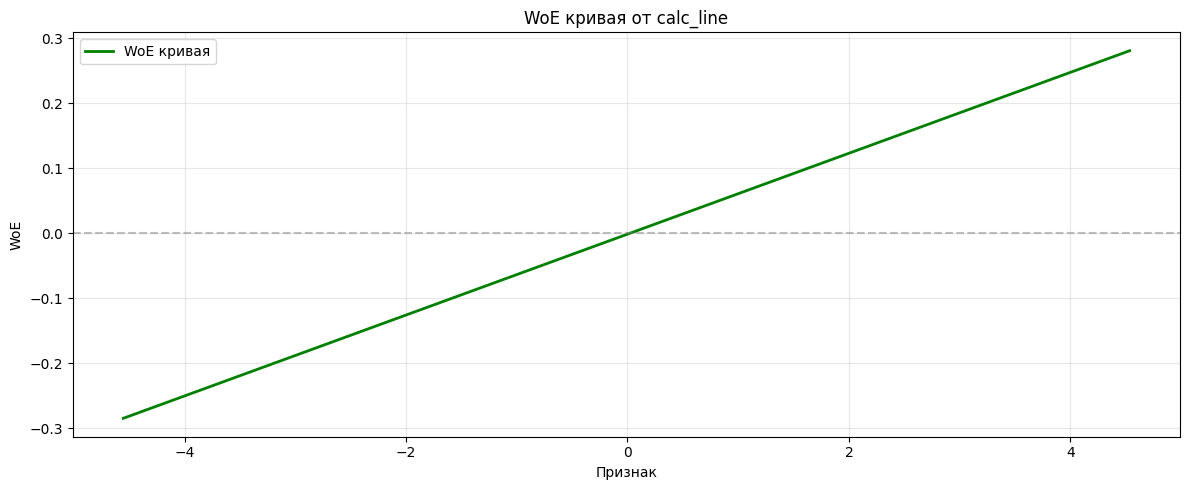

In [798]:
import matplotlib.pyplot as plt
# тест calc_line на датасете

feature = df["feature_1"]

buckets = calc_buckets(feature, 10)

df1 = pd.DataFrame({
    "value": feature,
    "bucket": buckets
})
overall_badrate = df["d4p12"].mean()
offset = logit(overall_badrate)

mean_feature = df1.groupby("bucket")["value"].mean()

line = calc_line(feature.values, df["d4p12"].values, mean_feature, offset)
print(line)

plt.figure(figsize=(12, 5))
plt.plot(mean_feature, line, 'g-', linewidth=2, label='WoE кривая')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Признак')
plt.ylabel('WoE')
plt.title('WoE кривая от calc_line')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [799]:
print(woe_transform(overall_badrate, offset))  # Должно быть 0

0.0


### Шаг3: собираем результаты по бакетам в один словарь (1 балл)

In [800]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    
    overall_badrate = target.mean()
    offset = logit(overall_badrate)

    df = pd.DataFrame({
    "value": values,
    "bucket": buckets
    })

    mean_feature = df.groupby("bucket")["value"].mean()
    
    line = calc_line(values, target, mean_feature, offset)
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset)

    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : line,
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

In [801]:
# протестируйте calc_buckets_info

buckets_info = calc_buckets_info(feature.values, df["d4p12"].values, buckets)

# Ключи
expected_keys = {"mean_feature", "line", "woe", "woe_lower", "woe_upper"}
assert expected_keys.issubset(buckets_info.keys())

# Длины совпадают
n_buckets = buckets_info["mean_feature"].shape[0]

assert len(buckets_info["line"]) == n_buckets
assert len(buckets_info["woe"]) == n_buckets
assert len(buckets_info["woe_lower"]) == n_buckets
assert len(buckets_info["woe_upper"]) == n_buckets

# Нет NaN и inf
for k in buckets_info:
    arr = np.asarray(buckets_info[k])
    assert not np.any(np.isnan(arr)), f"NaN в {k}"
    assert not np.any(np.isinf(arr)), f"Inf в {k}"

print("✓ Все базовые проверки пройдены")

# WoE и линия должны быть в одном масштабе
print("WoE диапазон:", buckets_info["woe"].min(), buckets_info["woe"].max())
print("Line диапазон:", buckets_info["line"].min(), buckets_info["line"].max())

✓ Все базовые проверки пройдены
WoE диапазон: -0.8010478764570725 0.9431856495205433
Line диапазон: -0.2849543913022448 0.28050365262470345


### Шаг 4: считаем метрики признака (2 балла)

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам. 

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

In [802]:
from sklearn.metrics import roc_auc_score

def calc_plot_title(
        model_values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    
    auc = roc_auc_score(target, model_values)

    df_temp = pd.DataFrame({
        'value': model_values,
        'target': target,
        'bucket': buckets
    })

    grouped = df_temp.groupby('bucket').agg({
        'target': ['count', 'sum'],  # всего наблюдений и "плохих"
        'value': 'mean'  # среднее значение признака в бакете
    })
    

    # формула выше
    woe, _, _ = woe_ci(target, buckets, offset)
    woe = woe.loc[grouped.index]
    total_bad = grouped[('target', 'sum')].sum()
    total_good = grouped[('target', 'count')].sum() - total_bad

    dist_bad = grouped[('target', 'sum')] / total_bad
    dist_good = (grouped[('target', 'count')] - grouped[('target', 'sum')]) / total_good

    IV = np.sum((dist_bad - dist_good) * woe)


    # Взвешенный R^2 
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете


    X = grouped[('value', 'mean')].values
    Y = woe.values
    weights = grouped[('target', 'count')].values
    
    # 1. Взвешенная линейная регрессия
    # Используем polyfit с весами
    coeffs = np.polyfit(X, Y, 1, w=weights)  # [slope, intercept]
    
    # 2. Предсказания
    y_pred = coeffs[0] * X + coeffs[1]
    
    # 3. Взвешенный R²
    weighted_mean_y = np.average(Y, weights=weights)
    
    ss_total = np.sum(weights * (Y - weighted_mean_y) ** 2)
    ss_residual = np.sum(weights * (Y - y_pred) ** 2)
    
    R_sqr = 1 - (ss_residual / ss_total) if ss_total != 0 else 0

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [803]:

np.random.seed(0)
n = 6000
x = np.random.normal(0, 1, n)
p = 1 / (1 + np.exp(-1.2 * x))
y = np.random.binomial(1, p)
buckets = pd.qcut(x, q=10, duplicates="drop")

print(calc_plot_title(x, y, buckets))





# ---------- TEST 2: немонотонный признак ----------

x2 = np.random.normal(0, 1, n)
p2 = 1 / (1 + np.exp(-x2**2 + 1))
y2 = np.random.binomial(1, p2)
buckets2 = pd.qcut(x2, q=10, duplicates="drop")

print(calc_plot_title(x2, y2, buckets2))







AUC = 0.780 IV = 1.136 R_sqr = 0.994 
AUC = 0.502 IV = 0.816 R_sqr = 0.000 


### Шаг 5: собираем все в одну функцию и строим график

In [804]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [805]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [806]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

<Axes: xlabel='feature', ylabel='Count'>

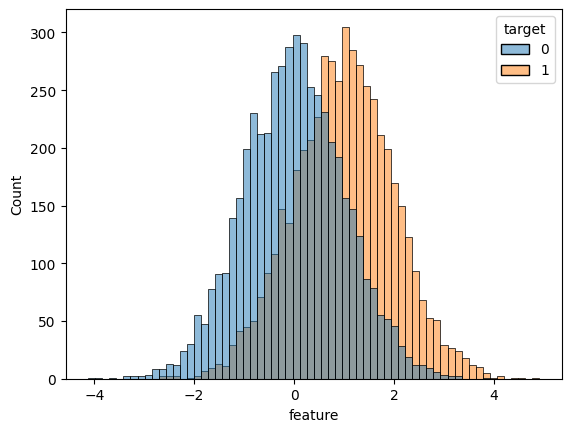

In [807]:
sns.histplot(df, x = 'feature', hue = 'target')

In [808]:
# запустите после того, как реализуете все функции 
woe_line(values=x, target=y, n_buckets=5)

In [809]:

np.random.seed(42)

# ---------- Генерация НЕМОНОТОННОГО признака ----------
sample_size = 10000

# Признак: нормальное распределение
x = np.random.normal(0, 1.5, sample_size)

# Таргет: вероятность зависит от КВАДРАТА признака (парабола!)
# Максимальная вероятность при x ≈ 0, минимальная на краях
p = 1 / (1 + np.exp(-(-3 * x**2 + 2)))  # p = sigmoid(-3*x² + 2)
y = np.random.binomial(1, p)

woe_line(values=x, target=y, n_buckets=5)

### Эксперименты (2 балл)

#### №1 

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)? 

In [810]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x, target=y, n_buckets=5)

In [811]:
sample_size = int(1e4)
noise_std = 2.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x, target=y, n_buckets=5)

In [812]:
sample_size = int(1e4)
noise_std = 5.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x, target=y, n_buckets=5)

In [813]:
sample_size = int(1e4)
noise_std = 25.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x, target=y, n_buckets=5)

In [814]:
sample_size = int(1e4)
noise_std = 50.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x, target=y, n_buckets=5)

In [815]:
sample_size = int(1e4)
noise_std = 150.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x, target=y, n_buckets=5)

#### №2 

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

скорее всего будет U-образная или перевернутая U-образная форма, потому что x² теряет знак и группирует вместе x и -x.

Высокий R² между значениями бакетов и WOE указывает на квадратичную форму. при малом числе бакетов (5) точки этой параболы случайно легли почти на прямую
Поэтому линейная регрессия (которая измеряет R²) даёт ложно высокий результат

In [816]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x**2, target=y, n_buckets=5)

#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

линия почти прямая. r^2 близко к 1, остальные метрики высокие. попробовать пролагорифмировать/клипнуть

In [817]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=np.exp(x), target=y, n_buckets=5)

## Часть 2. Строим ЛогРег. (5 баллов)

В этом пунтке попробуем применить все наши навыки 

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [818]:
df = pd.read_csv('lr_hw_dataset.csv', index_col=0, sep=',')
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.000119,0.029628,3.829880,1,8.825418,3.829880,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.062686,0.859062,6.189545,1,3.453220,6.189545,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.339225,0.614599,12.503629,1,-10.116061,12.503629,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.938956,0.090461,-1.080041,1,6.780814,-1.080041,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.067646,0.216199,1.367184,1,-10.638134,1.367184,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.949937,0.224437,5.263508,1,-9.959913,5.263508,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.860607,0.950708,0.581767,1,-1.645952,0.581767,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.242072,0.854085,0.995075,1,-5.565932,0.995075,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.056519,0.736255,2.980562,1,-4.517188,2.980562,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


Как вы выдите, ```feature_1, ..., feature_14``` - числа 
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

Размер датасета: 100000 строк × 16 столбцов

Типы данных:
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7       int64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15        str
d4p12           int64
dtype: object

Пропущенные значения:
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
d4p12         0
dtype: int64

Всего пропусков в датасете: 0

Уникальные значения категориального признака (feature_15):
2


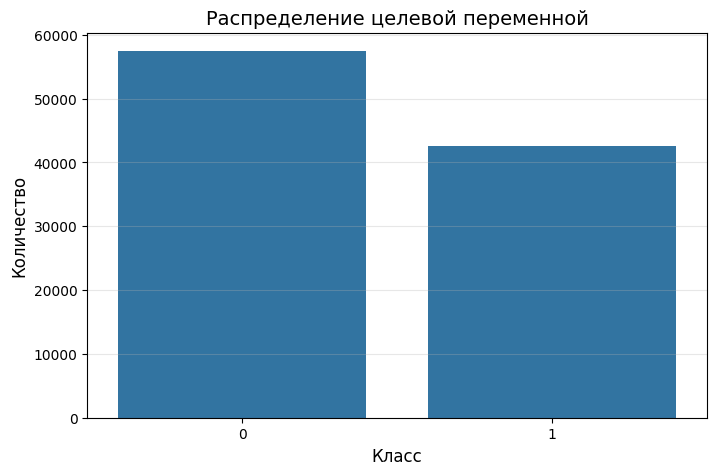


Баланс классов:
Класс 0: 57.46%
Класс 1: 42.54%


In [819]:

# Общая информация
print(f"Размер датасета: {df.shape[0]} строк × {df.shape[1]} столбцов")
print("\nТипы данных:")
print(df.dtypes)

print("\nПропущенные значения:")
print(df.isnull().sum())
print(f"\nВсего пропусков в датасете: {df.isnull().sum().sum()}")

print("\nУникальные значения категориального признака (feature_15):")
print(df['feature_15'].nunique())


plt.figure(figsize=(8, 5))
sns.countplot(x='d4p12', data=df)
plt.title('Распределение целевой переменной', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Процентное соотношение классов
class_ratio = df['d4p12'].value_counts(normalize=True) * 100
print(f"\nБаланс классов:")
print(f"Класс 0: {class_ratio[0]:.2f}%")
print(f"Класс 1: {class_ratio[1]:.2f}%")

### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении? 

Модель не переобучилась, хорошо обобщает, +- одни цифрфы. 

In [820]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

numeric = (
    df.select_dtypes(include=['float64', 'int64'])
      .columns
      .drop('d4p12')
      .tolist()
)


X_train_full, X_test_full, y_train, y_test = train_test_split(
    df,
    df['d4p12'],
    test_size=0.2,
    random_state=42
    )

X_train = X_train_full[numeric]
X_test = X_test_full[numeric]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

y_pred_train = log_reg.predict_proba(X_train_scaled)[:, 1]

# Предсказания
y_pred_train_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
print("График линейности на тренировочной выборке:")
woe_line(y_pred_train_proba, y_train.values, n_buckets=10).show()

print("График линейности на тестовой выборке:")
woe_line(y_pred_test_proba, y_test.values, n_buckets=10).show()



График линейности на тренировочной выборке:


График линейности на тестовой выборке:


### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество? нет

In [821]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_ohe = encoder.fit_transform(X_train_full[['feature_15']])
test_ohe = encoder.transform(X_test_full[['feature_15']])
ohe_cols = encoder.get_feature_names_out(['feature_15'])

train_ohe = pd.DataFrame(train_ohe, columns=ohe_cols, index=X_train_full.index)
test_ohe = pd.DataFrame(test_ohe, columns=ohe_cols, index=X_test_full.index)

X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train_full.index,
    columns=numeric
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test_full.index,
    columns=numeric
)

X_train_scaled = X_train_scaled.join(train_ohe)
X_test_scaled = X_test_scaled.join(test_ohe)


In [822]:
X_train_scaled

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15_A,feature_15_B
75220,-1.238383,0.001394,0.003999,0.212573,-0.785264,-1.142826,0.334305,0.418477,-1.142826,-2.615470,-0.948636,-0.827031,1.019980,-0.762459,0.0,1.0
48955,-1.293306,0.001614,0.003709,-0.534550,-0.863204,0.599605,0.334305,-0.222088,0.599605,1.535424,-0.955693,-0.929767,-0.166955,1.876449,0.0,1.0
44966,0.800332,0.003966,0.001059,0.701882,-0.734081,-0.833593,0.334305,-1.955577,-0.833593,0.802088,1.224204,0.930419,-0.202924,1.877665,1.0,0.0
13568,0.170290,-0.000351,0.003431,0.290460,-0.316232,0.106202,0.334305,-1.098553,0.106202,-1.153086,0.991722,1.104454,-0.203882,-0.761439,1.0,0.0
92727,0.105277,-0.000070,0.001604,1.718002,0.676578,-1.363143,0.334305,-1.525822,-1.363143,-0.844546,0.956160,1.080590,-0.209309,-0.736396,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.065441,0.001306,-0.001562,0.354974,0.396379,-1.097458,0.334305,-1.304520,-1.097458,-0.907105,0.985666,1.028499,-0.208625,1.880113,1.0,0.0
54886,-0.439550,0.002027,0.005558,0.037721,-0.865387,0.804402,-2.991283,-2.740476,0.804402,0.184203,-0.748394,-0.951603,-0.177476,0.309898,0.0,1.0
76820,0.091528,-0.010426,-0.000635,0.264363,-0.815800,-1.649848,0.334305,0.917439,-1.649848,-1.076036,0.985532,0.915038,-0.210026,0.572107,1.0,0.0
860,0.220143,0.004924,-0.002053,0.219924,2.222965,-1.398419,0.334305,2.115785,-1.398419,-0.104237,1.010301,0.769983,-0.209977,-0.749298,1.0,0.0


In [823]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]



y_pred_train = log_reg.predict_proba(X_train_scaled)[:, 1]

print("График линейности на тренировочной выборке:")
woe_line(y_pred_train_proba, y_train.values, n_buckets=10).show()

print("График линейности на тестовой выборке:")
woe_line(y_pred_test_proba, y_test.values, n_buckets=10).show()

График линейности на тренировочной выборке:


График линейности на тестовой выборке:


### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег). 

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

In [824]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.000119,0.029628,3.829880,1,8.825418,3.829880,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.062686,0.859062,6.189545,1,3.453220,6.189545,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.339225,0.614599,12.503629,1,-10.116061,12.503629,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.938956,0.090461,-1.080041,1,6.780814,-1.080041,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.067646,0.216199,1.367184,1,-10.638134,1.367184,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.949937,0.224437,5.263508,1,-9.959913,5.263508,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.860607,0.950708,0.581767,1,-1.645952,0.581767,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.242072,0.854085,0.995075,1,-5.565932,0.995075,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.056519,0.736255,2.980562,1,-4.517188,2.980562,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


In [825]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols_to_exclude = ['feature_15', 'd4p12']
cols_to_scale = [col for col in numeric_cols if col not in cols_to_exclude]

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [826]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-0.548819,0.022135,0.003239,0.211920,-0.967886,0.210007,0.332815,2.263847,0.210007,1.592167,-0.982160,-0.901311,-0.210452,-0.638033,B,1
1,0.432991,-0.000052,0.001767,0.318360,-0.141486,0.800366,0.332815,1.191395,0.800366,0.260211,0.834441,1.035536,-0.208521,-0.685011,A,0
2,0.484896,-0.000266,4.268636,0.787037,-0.385055,2.380075,0.332815,-1.517441,2.380075,0.521116,0.966214,0.910786,-0.211103,-0.135570,A,0
3,-0.485491,-0.014041,0.004835,-1.379211,-0.907275,-1.018397,0.332815,1.855683,-1.018397,-0.192418,-0.967811,-0.974697,-0.207823,1.635953,B,0
4,1.337861,0.002073,-0.001118,0.326767,-0.781997,-0.406131,0.332815,-1.621662,-0.406131,0.651130,0.977560,0.778507,-0.210577,-0.030950,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.164712,0.000206,0.004734,-1.397823,-0.773789,0.568683,0.332815,-1.486269,0.568683,0.332309,-1.025309,-1.149975,-0.210990,1.496990,B,0
99996,0.086292,-0.000439,0.002843,1.670670,-0.050176,-0.602633,0.332815,0.173447,-0.602633,0.387944,0.933589,1.025603,-0.192372,-0.744771,A,1
99997,0.412406,0.003175,0.000469,0.622382,-0.146445,-0.499228,0.332815,-0.609099,-0.499228,-0.818350,1.000430,0.983874,-0.211879,-0.337211,A,1
99998,-0.543757,-0.002398,0.003733,0.116334,-0.263843,-0.002483,0.332815,-0.399738,-0.002483,1.440869,-0.961369,-1.042024,0.193070,-0.558523,B,1


In [827]:
def robust_transform(x):
    return np.sign(x) * np.log(np.abs(x))

segment1= df[df['feature_15'] == 'A']
segment2= df[df['feature_15'] == 'B']

print("Грфик линейности для сегмента 1 до линеаризации:")
woe_line(values = segment1['feature_1'].values,
         target = segment1['d4p12'].values,
         n_buckets=5).show()

#values1 = np.log(segment1['feature_1'].values)
#segment1['feature_1'] = values1
values1 = robust_transform(segment1['feature_1'])

print("Грфик линейности для сегмента 1 после линеаризации:")
woe_line(values = values1.values,
         target = segment1['d4p12'].values,
         n_buckets=5).show()


Грфик линейности для сегмента 1 до линеаризации:


Грфик линейности для сегмента 1 после линеаризации:


In [828]:
segment1['feature_1'].describe()



count    49894.000000
mean         0.622959
std          0.773325
min          0.006308
25%          0.197873
50%          0.385031
75%          0.743967
max         14.863065
Name: feature_1, dtype: float64

In [829]:
segment2['feature_1'].describe()

count    50106.000000
mean        -0.620323
std          0.793130
min        -20.797828
25%         -0.741148
50%         -0.382865
75%         -0.193571
max         -0.006710
Name: feature_1, dtype: float64

In [830]:

print("Грфик линейности для сегмента 2 до линеаризации:")
woe_line(values = segment2['feature_1'].values,
         target = segment2['d4p12'].values,
         n_buckets=5).show()

#values2 = np.log(-segment2['feature_1'].values)
#segment2['feature_1'] = values2
#оставили монотонность но интерпретация нарушилась
values2 = robust_transform(segment2['feature_1'])
print("Грфик линейности для сегмента 2 после линеаризации:")
woe_line(values = values2.values,
         target = segment2['d4p12'].values,
         n_buckets=5).show()

Грфик линейности для сегмента 2 до линеаризации:


Грфик линейности для сегмента 2 после линеаризации:


In [831]:
woe_line(values = robust_transform(df['feature_1']).values,
         target = df['d4p12'].values,
         n_buckets=5).show()

In [832]:





woe_line(values = signed_sqrt(segment1['feature_1'].values).clip(min = 0.5, max = 1.1),
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = robust_transform(segment1['feature_1'].values),
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = segment2['feature_1'].values,
         target = segment2['d4p12'].values,
         n_buckets=5).show()

In [833]:


woe_line(values = segment1['feature_14'].values,
         target = segment1['d4p12'].values,
         n_buckets=5).show()



woe_line(values = segment2['feature_9'].values,
         target = segment2['d4p12'].values,
         n_buckets=5).show()


### фича вторая

In [834]:
#вроде хочется клипнуть, но тогда диапазоны не перекрываются, модель просто научится определять сегмент по значнению признака (больше или меньше 0) -> data leakage . 
woe_line(values = df['feature_3'].values,
         target = df['d4p12'].values,
         n_buckets=5).show()

woe_line(values = segment1['feature_3'].values.clip(min=0.03),
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = segment2['feature_3'].values.clip(max=0),
         target = segment2['d4p12'].values,
         n_buckets=5).show()

### фича третья

In [835]:
#AUC = 0.507   почти случайное угадывание (0.5)
#IV = 0.001    очень слабая предсказательная сила

woe_line(values = df['feature_8'].values,
         target = df['d4p12'].values,
         n_buckets=5).show()

woe_line(values = segment1['feature_8'].values,
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = segment2['feature_8'].values,
         target = segment2['d4p12'].values,
         n_buckets=5).show()

### фича четвертая

In [836]:
woe_line(values = df['feature_11'].values,
         target = df['d4p12'].values,
         n_buckets=5).show()

woe_line(values = segment1['feature_11'].values.clip(min=0.8),
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = robust_transform(segment2['feature_11'].values.clip(max=-0.75)),
         target = segment2['d4p12'].values,
         n_buckets=5).show()

In [837]:
woe_line(values = robust_transform(df['feature_12'].values),
         target = df['d4p12'].values,
         n_buckets=5).show()

woe_line(values = robust_transform(segment1['feature_12'].values),
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = robust_transform(segment2['feature_12'].values),
         target = segment2['d4p12'].values,
         n_buckets=5).show()

In [838]:

woe_line(values = signed_sqrt(segment1['feature_2'].values),
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = (segment2['feature_2'].values),
         target = segment2['d4p12'].values,
         n_buckets=5).show()

##  14 фичу можно лианеризовать на всем пространстве объектов

 но такие как фича 2 невозможно

In [839]:
woe_line(values = robust_transform(df['feature_14'].values.clip(min=-0.6, max=1.75)),
         target = df['d4p12'].values,
         n_buckets=5).show()
woe_line(values = (segment1['feature_14'].values.clip(min=-0.6)),
         target = segment1['d4p12'].values,
         n_buckets=5).show()

woe_line(values = (segment2['feature_14'].values.clip(min=-0.6)),
         target = segment2['d4p12'].values,
         n_buckets=5).show()

In [840]:

def robust_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

def identity(x):
    return x

def sqrt_pos(x):
    return np.sqrt(x)

def signed_sqrt(x):
    return np.sign(x) * np.sqrt(np.abs(x))

TRANSFORMS = {
    "raw": identity,
    "robust": robust_transform,
    "signed_sqrt": signed_sqrt
}

def apply_transform(x, func):
    x_new = func(x)
    mask = np.isfinite(x_new)
    return x_new[mask], mask

segments = {
    "A": df[df['feature_15'] == 'A'],
    "B": df[df['feature_15'] == 'B']
}

for col in cols_to_scale:
    for seg_name, seg_df in segments.items():

        print(f"\n{'='*70}")
        print(f"Фича: {col} | Сегмент: {seg_name}")
        print(f"{'='*70}")

        x_raw = seg_df[col].values
        y = df.loc[seg_df.index, 'd4p12'].values

        for name, func in TRANSFORMS.items():
            try:
                x_tr, mask = apply_transform(x_raw, func)

                print(f"\n--- Преобразование: {name} ---")
                woe_line(
                    values=x_tr,
                    target=y[mask],
                    n_buckets=5
                ).show()

            except Exception as e:
                print(f"{name}: не применимо ({e})")


Фича: feature_1 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_1 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_2 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_2 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_3 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_3 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_4 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_4 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_5 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_5 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_6 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_6 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_7 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_7 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_8 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_8 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_9 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_9 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_10 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_10 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_11 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_11 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_12 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_12 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_13 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_13 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_14 | Сегмент: A

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---



Фича: feature_14 | Сегмент: B

--- Преобразование: raw ---



--- Преобразование: robust ---



--- Преобразование: signed_sqrt ---


In [841]:
def calc_r2_for_feature(values, target, n_buckets=5):
    buckets = calc_buckets(values, n_buckets)
    
    df_tmp = pd.DataFrame({
        "value": values,
        "target": target,
        "bucket": buckets
    })

    grouped = df_tmp.groupby("bucket").agg({
        "value": "mean",
        "target": ["count", "sum"]
    })

    woe, _, _ = woe_ci(target, buckets, offset=0)
    woe = woe.loc[grouped.index]

    X = grouped[("value", "mean")].values
    Y = woe.values
    weights = grouped[("target", "count")].values

    coeffs = np.polyfit(X, Y, 1, w=weights)
    y_pred = coeffs[0] * X + coeffs[1]

    weighted_mean_y = np.average(Y, weights=weights)
    ss_total = np.sum(weights * (Y - weighted_mean_y) ** 2)
    ss_res = np.sum(weights * (Y - y_pred) ** 2)

    return 1 - ss_res / ss_total if ss_total > 0 else np.nan

results = []

segments = {
    "A": df[df["feature_15"] == "A"],
    "B": df[df["feature_15"] == "B"]
}

def calc_auc_for_feature(values, target):
    """Рассчитывает AUC для одного признака"""
    
    # Убираем NaN
    mask = np.isfinite(values)
    if mask.sum() < 2:
        return np.nan
    
    values_clean = values[mask]
    target_clean = target[mask]
    
    # Если все значения таргета одинаковые, AUC не определен
    if len(np.unique(target_clean)) < 2:
        return np.nan
    
    try:
        auc = roc_auc_score(target_clean, values_clean)
        return auc
    except:
        return np.nan

results = []


def calc_iv_for_feature(values, target, n_buckets=5):
    """Рассчитывает Information Value (IV) для признака"""
    # Биннинг
    buckets = calc_buckets(values, n_buckets)
    
    df_tmp = pd.DataFrame({
        "value": values,
        "target": target,
        "bucket": buckets
    })
    
    # Группируем по бинам
    grouped = df_tmp.groupby("bucket").agg({
        "target": ["count", "sum"]  # всего наблюдений и "плохих" (класс 1)
    })
    
    # Расчет WoE и IV
    total_bad = grouped[("target", "sum")].sum()
    total_good = grouped[("target", "count")].sum() - total_bad
    
    # Проверка на минимальное количество наблюдений
    if total_bad == 0 or total_good == 0:
        return np.nan
    
    # Доли "плохих" и "хороших" в каждом бине
    dist_bad = grouped[("target", "sum")] / total_bad
    dist_good = (grouped[("target", "count")] - grouped[("target", "sum")]) / total_good
    
    # Расчет WoE
    woe = np.log(dist_good / dist_bad)
    
    # Расчет IV
    IV = np.sum((dist_good - dist_bad) * woe)
    
    return IV
for col in cols_to_scale:
    for name, func in TRANSFORMS.items():
        r2_vals = {}

        valid = True
        for seg_name, seg_df in segments.items():
            try:
                x = func(seg_df[col].values)
                mask = np.isfinite(x)

                r2 = calc_r2_for_feature(
                    x[mask],
                    df.loc[seg_df.index, "d4p12"].values[mask]
                )

                r2_vals[seg_name] = r2

            except Exception:
                valid = False
                break

        if valid:
            results.append({
                "feature": col,
                "transform": name,
                "R2_A": r2_vals["A"],
                "R2_B": r2_vals["B"],
                "R2_min": min(r2_vals["A"], r2_vals["B"]),  
                "AUC_A": calc_auc_for_feature(
                    func(segments["A"][col].values),
                    segments["A"]["d4p12"].values
                ),
                "AUC_B": calc_auc_for_feature(  
                    func(segments["B"][col].values),
                    segments["B"]["d4p12"].values),
                "IV_A": calc_iv_for_feature(
                    func(segments["A"][col].values),
                    segments["A"]["d4p12"].values
                ),
                "IV_B": calc_iv_for_feature(
                    func(segments["B"][col].values),
                    segments["B"]["d4p12"].values
                )
            })

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(
    by="R2_min",
    ascending=False
)



In [842]:
results_df

,feature,transform,R2_A,R2_B,R2_min,AUC_A,AUC_B,IV_A,IV_B
18,feature_7,raw,1.000000,1.000000,1.000000,0.500132,0.500241,7.746285e-07,0.000003
20,feature_7,signed_sqrt,1.000000,1.000000,1.000000,0.500132,0.500241,7.746285e-07,0.000003
19,feature_7,robust,1.000000,1.000000,1.000000,0.500132,0.500241,7.746285e-07,0.000003
33,feature_12,raw,0.984827,0.996238,0.984827,0.812998,0.738909,1.403957e+00,0.775335
34,feature_12,robust,0.978303,0.994144,0.978303,0.812998,0.738909,1.403957e+00,0.775335
35,feature_12,signed_sqrt,0.978030,0.994127,0.978030,0.812998,0.738909,1.403957e+00,0.775335
2,feature_1,signed_sqrt,0.925404,0.942440,0.925404,0.376966,0.591593,1.763628e-01,0.095272
30,feature_11,raw,0.935074,0.920464,0.920464,0.827973,0.753219,1.591186e+00,0.898572
23,feature_8,signed_sqrt,0.920889,0.905716,0.905716,0.509872,0.504740,1.163887e-03,0.000295
22,feature_8,robust,0.897933,0.933198,0.897933,0.509872,0.504740,1.163887e-03,0.000295


In [843]:
# Находим максимальное значение R2_min для каждого признака
max_r2_per_feature = results_df.groupby('feature')['R2_min'].max().reset_index()

# Объединяем с исходными данными, чтобы получить все колонки
best_transforms = results_df.merge(
    max_r2_per_feature,
    on=['feature', 'R2_min'],
    how='inner'
)

# Удаляем дубликаты на случай, если несколько преобразований дают одинаковый R2_min
best_transforms = best_transforms.drop_duplicates(subset=['feature', 'R2_min'])

print("Лучшие преобразования для каждого признака:")
print("=" * 70)
print(best_transforms[['feature', 'transform', 'R2_A', 'R2_B', 'R2_min', 'AUC_A', 'AUC_B', 'IV_A', 'IV_B']].to_string(index=False))

Лучшие преобразования для каждого признака:
   feature   transform     R2_A     R2_B   R2_min    AUC_A    AUC_B         IV_A     IV_B
 feature_7         raw 1.000000 1.000000 1.000000 0.500132 0.500241 7.746285e-07 0.000003
feature_12         raw 0.984827 0.996238 0.984827 0.812998 0.738909 1.403957e+00 0.775335
 feature_1 signed_sqrt 0.925404 0.942440 0.925404 0.376966 0.591593 1.763628e-01 0.095272
feature_11         raw 0.935074 0.920464 0.920464 0.827973 0.753219 1.591186e+00 0.898572
 feature_8 signed_sqrt 0.920889 0.905716 0.905716 0.509872 0.504740 1.163887e-03 0.000295
feature_14      robust 0.820513 0.838964 0.820513 0.353515 0.389051 2.518656e-01 0.143612
 feature_3 signed_sqrt 0.712508 0.589790 0.589790 0.658652 0.377769 2.982717e-01 0.175959
feature_10         raw 0.464395 0.480849 0.464395 0.503048 0.503193 2.382380e-04 0.000442
feature_13 signed_sqrt 0.311221 0.337542 0.311221 0.502765 0.502092 6.191718e-04 0.000187
 feature_5 signed_sqrt 0.286718 0.413313 0.286718 0.4990

In [844]:
good_features = ['feature_7', "feature_12", "feature_1", "feature_11", "feature_14", "feature_3"]  

In [845]:
for col in cols_to_scale: 
    print(f"\n{'='*60}") 
    print(f"WOE для фичи: {col}") 
    print(f"{'='*60}") 
    woe_line(values = (df[col]).values, target = df['d4p12'].values, n_buckets=5).show()



WOE для фичи: feature_1



WOE для фичи: feature_2



WOE для фичи: feature_3



WOE для фичи: feature_4



WOE для фичи: feature_5



WOE для фичи: feature_6



WOE для фичи: feature_7



WOE для фичи: feature_8



WOE для фичи: feature_9



WOE для фичи: feature_10



WOE для фичи: feature_11



WOE для фичи: feature_12



WOE для фичи: feature_13



WOE для фичи: feature_14


### Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [846]:
numeric_cols

['feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'd4p12']

In [847]:
X_train_full

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
75220,-3.276009,0.143596,4.897477,-0.000071,0.212638,-1.586430,1,-0.411429,-1.586430,-9.350816,-504.550730,-0.901976,5850.023634,0.000002,B,1
48955,-3.421033,0.183404,4.217062,-0.441243,0.134292,5.381263,1,-3.621129,5.381263,11.289332,-506.390657,-1.139742,204.859870,0.998572,B,0
44966,2.107236,0.609640,-1.996910,0.288863,0.264088,-0.349859,1,-12.307173,-0.349859,7.642847,61.975572,3.165360,33.788992,0.999033,A,1
13568,0.443606,-0.172567,3.565141,0.045921,0.684119,3.408225,1,-8.012853,3.408225,-2.079172,1.360393,3.568137,29.229936,0.000388,A,1
92727,0.271936,-0.121807,-0.719769,0.888877,1.682114,-2.467440,1,-10.153786,-2.467440,-0.544970,-7.911739,3.512906,3.420994,0.009865,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.166750,0.127571,-8.144752,0.084016,1.400451,-1.405009,1,-9.044898,-1.405009,-0.856041,-0.218556,3.392352,6.671972,0.999959,A,0
54886,-1.166682,0.258181,8.552861,-0.103320,0.132097,6.200212,0,-16.240087,6.200212,4.570443,-452.341629,-1.190278,154.819304,0.405785,B,1
76820,0.235633,-1.998280,-5.970398,0.030511,0.181943,-3.613927,1,2.088737,-3.613927,-1.696046,-0.253385,3.129764,0.008511,0.505006,A,0
860,0.575242,0.783176,-9.294548,0.004270,3.236575,-2.608502,1,8.093323,-2.608502,3.136185,6.204570,2.794056,0.243361,0.004983,A,0


In [848]:
from sklearn.pipeline import Pipeline


needed_cols = ["feature_11", "feature_12", "feature_1", "feature_3", "feature_14", "feature_13", "feature_5"]

#needed_cols = good_features


X_train_full, X_test_full, y_train, y_test = train_test_split(
    df,
    df['d4p12'],
    test_size=0.2,
    random_state=42,
)
X_train_full["feature_14"] = robust_transform(X_train_full["feature_14"].values.clip(min=-0.5, max=1.75))
X_test_full["feature_14"] = robust_transform(X_test_full["feature_14"].values.clip(min=-0.5, max=1.75))



def proba_to_logit(proba):
    """Преобразует вероятность в logit: log(p/(1-p))"""
    eps = 1e-15
    proba = np.clip(proba, eps, 1 - eps)
    return np.log(proba / (1 - proba))

def train_segment_model(segment_value, X_train, y_train, features):
    """Обучает модель для конкретного сегмента"""
    # Выбираем данные сегмента
    segment_mask = X_train['feature_15'] == segment_value
    X_segment = X_train.loc[segment_mask, features].copy()
    y_segment = y_train[segment_mask]
    
    if len(X_segment) == 0:
        return None
    
    # Применяем преобразования для сегмента
    if segment_value == 'A':
        # Применяем клиппинг для сегмента A
        X_segment['feature_3'] = X_segment['feature_3'].clip(lower=0.03)
        X_segment['feature_11'] = robust_transform(X_segment['feature_11'].values.clip(min=0.8))
        X_segment['feature_12'] = robust_transform(X_segment['feature_12'].values)
        X_segment['feature_1'] = signed_sqrt((X_segment['feature_1'].values).clip(min = 0.25, max = 1.6))

    elif segment_value == 'B':
        # Применяем клиппинг для сегмента B
        X_segment['feature_3'] = X_segment['feature_3'].clip(upper=0)
        X_segment['feature_11'] = robust_transform(X_segment['feature_11'].values.clip(max=-0.75))
        X_segment['feature_12'] = robust_transform(X_segment['feature_12'].values)
        X_segment['feature_1'] = signed_sqrt(X_segment['feature_1'].values.clip(min = -1.6, max = -0.2))
    
    # Создаем и обучаем модель с StandardScaler
    model = Pipeline([
        ('logreg', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    model.fit(X_segment, y_segment)
    return model

# Обучаем модели
print("Обучаем модели для сегментов...")
model_A = train_segment_model('A', X_train_full, y_train, needed_cols)
model_B = train_segment_model('B', X_train_full, y_train, needed_cols)

def apply_segment_transformations(segment_value, X_segment):
    """Применяет преобразования к данным сегмента"""
    X = X_segment.copy()
    
    if segment_value == 'A':
        X['feature_3'] = X['feature_3'].clip(lower=0.03)
        X['feature_11'] = robust_transform(X['feature_11'].values.clip(min=0.8))
        X['feature_12'] = robust_transform(X['feature_12'].values)
        X['feature_1'] = signed_sqrt(X['feature_1'].values.clip(min = 0.25, max = 1.6))
    elif segment_value == 'B':
        X['feature_3'] = X['feature_3'].clip(upper=0)
        X['feature_11'] = robust_transform(X['feature_11'].values.clip(max=-0.75))
        X['feature_12'] = robust_transform(X['feature_12'].values)
        X['feature_1'] = signed_sqrt(X['feature_1'].values.clip(min = -1.6, max = -0.2))
    
    return X

def calculate_final_logit(X, model_A, model_B):
    """Рассчитывает итоговый logit по формуле из задания"""
    final_logits = np.zeros(len(X))
    
    # Сегмент A
    mask_A = X['feature_15'] == 'A'
    if model_A is not None and mask_A.any():
        X_A = X.loc[mask_A, needed_cols].copy()
    
        X_A_transformed = apply_segment_transformations('A', X_A)
     
        proba_A = model_A.predict_proba(X_A_transformed)[:, 1]
    
        logit_A = proba_to_logit(proba_A)
    
        final_logits[mask_A] = 1.0 * logit_A
    
    # Сегмент B
    mask_B = X['feature_15'] == 'B'
    if model_B is not None and mask_B.any():
        X_B = X.loc[mask_B, needed_cols].copy()
     
        X_B_transformed = apply_segment_transformations('B', X_B)
     
        proba_B = model_B.predict_proba(X_B_transformed)[:, 1]
      
        logit_B = proba_to_logit(proba_B)
   
        final_logits[mask_B] = 1.0 * logit_B
    
    return final_logits

def get_final_probabilities(X, model_A, model_B):
    """Получает финальные вероятности через формулу с logits"""
    # Получаем logits
    logits = calculate_final_logit(X, model_A, model_B)
    # Преобразуем logit обратно в вероятность
    probabilities = 1 / (1 + np.exp(-logits))
    return probabilities


y_pred_train_logits = calculate_final_logit(X_train_full, model_A, model_B)
y_pred_train_proba = get_final_probabilities(X_train_full, model_A, model_B)

y_pred_test_logits = calculate_final_logit(X_test_full, model_A, model_B)
y_pred_test_proba = get_final_probabilities(X_test_full, model_A, model_B)


print(calc_plot_title(
    model_values = y_pred_train_proba,
    target = y_train.values,
    buckets = calc_buckets(y_pred_train_proba, 10  )
    )    
)

print(calc_plot_title(
    model_values = y_pred_test_proba,
    target = y_test.values,
    buckets = calc_buckets(y_pred_test_proba, 10  )
    )    
)

Обучаем модели для сегментов...
AUC = 0.875 IV = 2.626 R_sqr = 0.950 
AUC = 0.871 IV = 2.554 R_sqr = 0.945 


# Часть 3. Бонус. (3 балла)

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

$$
P(x_i \mid y = 1) = \frac{P(y = 1 \mid x_i)\, P(x_i)}{P(y = 1)}
$$

$$
P(x_i \mid y = 0) = \frac{P(y = 0 \mid x_i)\, P(x_i)}{P(y = 0)}
$$




Подставим выражения в определение WoE:

$$
\mathrm{WoE}(x_i)
= \ln \left(
\frac{
\frac{P(y = 1 \mid x_i)\, P(x_i)}{P(y = 1)}
}{
\frac{P(y = 0 \mid x_i)\, P(x_i)}{P(y = 0)}
}
\right)
$$

Сократим \( P(x_i) \):

$$
\mathrm{WoE}(x_i)
= \ln \left(
\frac{P(y = 1 \mid x_i)}{P(y = 0 \mid x_i)}
\cdot
\frac{P(y = 0)}{P(y = 1)}
\right)
$$



$$
\ln(ab) = \ln a + \ln b
$$

 получаем:

$$
\mathrm{WoE}(x_i)
=
\ln \frac{P(y = 1 \mid x_i)}{P(y = 0 \mid x_i)}
-
\ln \frac{P(y = 1)}{P(y = 0)}
$$


#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

Подставим определение \( \mathrm{badrate}_i \):

$$
\mathrm{logit}(\mathrm{badrate}_i)
=
\ln \left(
\frac{
\frac{B_i}{B_i + G_i}
}{
1 - \frac{B_i}{B_i + G_i}
}
\right)
$$

Упростим знаменатель:

$$
1 - \frac{B_i}{B_i + G_i}
=
\frac{G_i}{B_i + G_i}
$$

Тогда:

$$
\mathrm{logit}(\mathrm{badrate}_i)
=
\ln \left(
\frac{B_i}{G_i}
\right)
$$



$$
\mathrm{logit}(\mathrm{badrate})
=
\ln \left(
\frac{B}{G}
\right)
$$




Рассмотрим разность:

$$
\mathrm{logit}(\mathrm{badrate}_i)
-
\mathrm{logit}(\mathrm{badrate})
=
\ln \left( \frac{B_i}{G_i} \right)
-
\ln \left( \frac{B}{G} \right)
$$


$$
=
\ln \left(
\frac{B_i / G_i}{B / G}
\right)
=
\ln \left(
\frac{B_i / B}{G_i / G}
\right)
$$

#### **Упражнение 3**

Пусть даны два дискретных распределения: 

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где 

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**






## Вывод через WoE:

### Шаг 1: Определение WoE

Weight of Evidence для значения \( x_i \) определяется как:

$$
\text{WoE}_i = \ln \left( \frac{g_i}{b_i} \right)
$$

Или, что эквивалентно:

$$
\text{WoE}_i = \ln \left( \frac{P(x = x_i \mid y = 0)}{P(x = x_i \mid y = 1)} \right)
$$



$$
D_{KL}(B \parallel G) = \sum_{i=1}^n b_i \ln \left( \frac{b_i}{g_i} \right)
$$

Заметим, что:

$$
\ln \left( \frac{b_i}{g_i} \right) = -\ln \left( \frac{g_i}{b_i} \right) = -\text{WoE}_i
$$

Следовательно:

$$
D_{KL}(B \parallel G) = \sum_{i=1}^n b_i \cdot (-\text{WoE}_i) = -\sum_{i=1}^n b_i \cdot \text{WoE}_i
$$



$$
D_{KL}(G \parallel B) = \sum_{i=1}^n g_i \ln \left( \frac{g_i}{b_i} \right)
$$

Здесь:

$$
\ln \left( \frac{g_i}{b_i} \right) = \text{WoE}_i
$$

Следовательно:

$$
D_{KL}(G \parallel B) = \sum_{i=1}^n g_i \cdot \text{WoE}_i
$$



$$
IV_x = D_{KL}(B \parallel G) + D_{KL}(G \parallel B)
$$

$$
IV_x = \left[ -\sum_{i=1}^n b_i \cdot \text{WoE}_i \right] + \left[ \sum_{i=1}^n g_i \cdot \text{WoE}_i \right]
$$

$$
IV_x = \sum_{i=1}^n (g_i - b_i) \cdot \text{WoE}_i
$$


$$
\boxed{IV_x = \sum_{i=1}^n \left[ P(x = x_i \mid y = 0) - P(x = x_i \mid y = 1) \right] \cdot \ln \left( \frac{P(x = x_i \mid y = 0)}{P(x = x_i \mid y = 1)} \right)}
$$